# Introduction to Digital Forensics for cybercrime
#### Assignment 3

**Group 5**<br/>
Fatema Alammal s2058502<br/>
Ellen Wittingen s2095610<br/>
Anniek Megens s1982869<br/>
Jelte van Bommel s2136074<br/>
Denis Arva s2188511<br/>
Joel Tyhaar s2138603<br/>


## Introduction, motivation and goals
In the recent COVID19-pandemic our daily activities for school, work, shopping and many others have been forced to go online. It is essential that these online services remain working to complete our daily tasks. However, bad actors recognize this as well and have started targeted DDoS attacks against medical organizations, delivery services, gaming and educational platforms.  In Q1 of 2020 there were twice as many DDoS attacks reported than in Q4 of 2019 (Kupreev et al, 2020). Those DDoS attacks can be bought for as little as 25$ per hour on so called 'Booter' websites (Makrushin, 2017). These are websites that offers a DDoS attack as a service to customers. Supposedly so customers can stress test their own server(s), if they lack the resources or are equipped with less powerful machines than a booter service could offer. The use of a booter can be legal in the case that the attack targets one’s own device, given that the terms and conditions of any service being used - for example the internet service provider- are not violated. The contrary case, where an attack is performed without the owner's consent, such that a platform becomes unavailable, is illegal. The website owner that is under attack is no longer able to serve his users, is running into the risk of losing reputation and revenues or even having users switch to competitors, resulting in long-term damages to the business.

In 2013, the cybersecurity journalist Brian Krebs made the SQL database dump of one of these booter websites, TWBooter, available on his site: krebsonsecurity.com. After being attacked in March 2013, Krebs began to investigate the source of the attack. He found out that somebody paid for a DDoS attack to shut down his website through TWBooter. He was able to access TWBooter’s database archive and get hold of its database, which he then uploaded to his website. Such a database dump is a unique opportunity to look under the hood of these booter websites, and may give valuable insights into the operation of these booters. This report covers the analysis of the database, which was filtered on the attacks only. The main goal of this analysis is to understand the type as well as the scale of the attacks performed through TWBooter, to ultimately aid in preventing DDoS attacks. 

Kupreev, O. Badovskaya, E. Gutnikov, A. (2020, May 6). DDoS attacks in Q1 2020. Retrieved October 16, 2020 from https://securelist.com/ddos-attacks-in-q1-2020/96837/

Makrushin, D. (2017, March 23). The cost of launching a DDoS attack. Retrieved October 16, 2020 from https://securelist.com/the-cost-of-launching-a-ddos-attack/77784/


## Methodology/Results
The database dump which contains the details about the attacks caused by TWBooter in 2013 is hosted on krebsonsecurity.com. This dump is a SQL database dump and therefore hard to analyze without using SQL queries. Thus the 'attack' table of the dump has been exported to an Excel document by Jair Santanna. This dump has been saved as a CSV file with Microsoft Office Excel. This CSV file is also included in the repository. This dump can now be imported into a pandas dataframe for further analysis. This analysis will contain quantitative statistics on the leaked database.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df_original = pd.read_csv('table_attack_twbooter.csv')
df_original.head()

,id,processid,victim,port_service`_type,type,duration,time,stopped,client_attacker,server_used_in_th_attack
0,1,5672,91.214.20.52,80,ESSYN,33,1358989954,1,1,94.102.49.76
1,2,29065,91.214.20.52,80,UDP,1783,1358990329,1,1,93.174.93.30
2,3,23005,78.31.8.124,80,ESSYN,393,1358991360,0,1,89.248.172.97
3,4,29411,199.204.44.188,80,ESSYN,60,1358995416,0,4,93.174.93.30
4,5,19298,http://chrome-mods.com,80,RUDY,50000,1358995471,1,3,72.9.144.80


Unfortunately the data in the dump is not consistent, some victim URL's contain ```'http://'``` , some contain ```https://```, some contain no prefix. Some victim domains start with www., some victim URL's contain paths, some IP-addresses use comma's, some use dots. As can be seen below:

In [2]:
df_original.query('"http://www.leakforums.org/index.php" in victim')[:1]

,id,processid,victim,port_service`_type,type,duration,time,stopped,client_attacker,server_used_in_th_attack
1911,1916,26905,http://www.leakforums.org/index.php,80,HTTPGET,3500,1359149778,1,126,67.222.156.241


Some of the victims are names (which we suspect to be in-game names of some game).

In [3]:
df_original.query('"xgoonx503" in victim')[:1]

,id,processid,victim,port_service`_type,type,duration,time,stopped,client_attacker,server_used_in_th_attack
850,853,4045,xgoonx503,80,SCLOUD,15,1359084966,0,15,89.248.172.106


Therefore we will normalize the victim column and add columns indicating whether the URL contained 'http' or 'https', for later analysis. 

In [4]:
df = df_original.assign(is_http=[True if "http" in x else False for x in df_original['victim']])
df = df.assign(is_https=[True if "https" in x else False for x in df['victim']])
df['victim'] = df['victim'].map(lambda x: x.replace(',', '.').replace('https://', '').replace('http://', '').replace('www.', '').split('/')[0])
df['server_used_in_th_attack'] = df['server_used_in_th_attack'].map(lambda x: str(x).replace(',', '.').replace('https://', '').replace('http://', ''))

The victim column contains both IP-addresses and domains, but also names (which we suspect to be in-game names). We can use a regular expression to add a column that indicates whether the victim is an IP-address or something else. This will come in useful later in the analysis.

In [5]:
import re
regex = re.compile('^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$')
df = df.assign(is_ip=[regex.match(x) != None for x in df['victim']])
df.head()

,id,processid,victim,port_service`_type,type,duration,time,stopped,client_attacker,server_used_in_th_attack,is_http,is_https,is_ip
0,1,5672,91.214.20.52,80,ESSYN,33,1358989954,1,1,94.102.49.76,False,False,True
1,2,29065,91.214.20.52,80,UDP,1783,1358990329,1,1,93.174.93.30,False,False,True
2,3,23005,78.31.8.124,80,ESSYN,393,1358991360,0,1,89.248.172.97,False,False,True
3,4,29411,199.204.44.188,80,ESSYN,60,1358995416,0,4,93.174.93.30,False,False,True
4,5,19298,chrome-mods.com,80,RUDY,50000,1358995471,1,3,72.9.144.80,True,False,False


Now that we have normalized the victim column, we can start with the analysis. 
### 1. The total number of attack records
The database dump contains 48733 attack records

In [6]:
print('The database dump contains: {}'.format(df_original.shape[0]))
print('Out of which {} are attacks directly on IP addresses, and {} are attacks on other victims'.format(df.query('is_ip').shape[0], df.query('not is_ip').shape[0]))

The database dump contains: 48773
Out of which 41666 are attacks directly on IP addresses, and 7107 are attacks on other victims


### 2. The number of unique users
These records are created by 277 unique users. This does not imply that there are 277 users registered on TWBooter, but that there are 277 unique users that are part of this dump that conducted an attack. Thus there are likely more than 277 users registered.

In [7]:
df.client_attacker.unique().shape[0]

277

### 3. Top 10 victim IP Addresses
Using our added column 'is_ip', which indicates if the victim is an IP Address or something else (e.g. a domainname or in-game name), we can find the most attacked IP-addresses in this dataset and the duration they have been under attack for.

In [8]:
top_10_attacked_ip = df.query('is_ip').groupby('victim') .agg({'id':'count', 'duration': 'sum'}).rename(columns={'id':'amount of attacks', 'duration': 'duration in seconds'})
top_10_attacked_ip['duration in days'] = top_10_attacked_ip['duration in seconds'].apply(lambda x: x/(60*60*24))
top_10_attacked_ip.sort_values('amount of attacks', ascending=False)[:10]

,amount of attacks,duration in seconds,duration in days
victim,,,
87.106.136.156,1162,97950,1.133681
212.7.214.197,799,47940,0.554861
72.9.144.6,304,1244766,14.407014
70.39.68.226,285,440391,5.097118
176.31.90.154,280,58400,0.675926
186.202.153.45,244,146400,1.694444
69.162.77.11,225,101340,1.172917
198.1.122.66,208,1059898,12.267338
100.42.216.59,189,93900,1.086806


However, these IP Addresses have the largest amount of attacks launched against them, this does not indicate how long these IP-addresses have been under attack. There are ip addresses that have been under attack for longer durations of time. Characterizing a top 10 of victims is thus hard to do. We would classify the following IP addresses as the top 10, due to the fact that these IP addresses were attacked for the longest duration of time and therefore used the most amount of resources.

In [9]:
top_10_attacked_ip.sort_values('duration in seconds', ascending=False)[:10]

,amount of attacks,duration in seconds,duration in days
victim,,,
204.27.58.194,9,2835460,32.817824
198.144.120.189,6,2500300,28.938657
174.120.6.116,7,2133556,24.693935
50.62.64.1,3,1500000,17.361111
72.9.144.6,304,1244766,14.407014
198.154.220.66,8,1223640,14.162500
198.1.122.66,208,1059898,12.267338
173.231.26.68,6,993107,11.494294
4.31.2.152,3,835431,9.669340


### 4. Top 10 victim domain names
Using the above code we can also analyze the records that do not have an IP-address as the victim. The most amount of attacks have been launched against the following domains:

In [10]:
top_10_attacked_domain = df.query('not is_ip').groupby('victim') .agg({'id':'count', 'duration': 'sum'}).rename(columns={'id':'amount of attacks', 'duration': 'duration in seconds'})
top_10_attacked_domain['duration in days'] = top_10_attacked_domain['duration in seconds'].apply(lambda x: x/(60*60*24))
top_10_attacked_domain.sort_values('amount of attacks', ascending=False)[:10]

,amount of attacks,duration in seconds,duration in days
victim,,,
relog.co.il,638,600731,6.952905
rewards.yourpshome.net,635,38100,0.440972
pshomecentral.net,383,14880,0.172222
ajnabi.vchats.info,373,229596,2.657361
nordicmakten.com,189,109055,1.262211
ajnabi.pkfun.net,186,101308,1.172546
yourpshome.net,186,155175,1.796007
violvocal.com,110,392415,4.541840
nordicmafia.net,107,64065,0.741493


The victims that have been under attack for the longest amount of time are the following IP addresses. As we can see some of the IP addresses that have the most amount of attacks launched against them, also have been under attack for long durations. 

In [11]:
top_10_attacked_domain.sort_values('duration in seconds', ascending=False)[:10]

,amount of attacks,duration in seconds,duration in days
victim,,,
chrome-mods.com,25,4432302,51.299792
buttonmashers.org,6,2625952,30.392963
theblazingtech.com,7,1376588,15.932731
relog.co.il,638,600731,6.952905
hf143.net,2,556954,6.446227
violvocal.com,110,392415,4.541840
adow.fr,33,237600,2.750000
ajnabi.vchats.info,373,229596,2.657361
ekstrabladet.dk,4,205881,2.382882


### 5. The longest attack duration
As we have seen above in 4 and 3, the longest combined attack duration has been against chrome-mods.com. The attack durations of individual records seem to be limited to 500.000 seconds (roughly 5 days and 19 hours) as can be seen here:

In [12]:
df.sort_values('duration', ascending=False)[:10]

,id,processid,victim,port_service`_type,type,duration,time,stopped,client_attacker,server_used_in_th_attack,is_http,is_https,is_ip
1860,1865,9142,204.27.58.194,80,ESSYN,500000,1359147910,1,3,89.248.172.96,False,False,True
1865,1870,24163,204.27.58.194,80,ARME,500000,1359147943,1,3,89.248.172.96,True,False,True
19482,19525,6410,chrome-mods.com,80,ARME,500000,1360759739,1,3,89.248.160.146,True,False,False
1858,1863,9131,buttonmashers.org,80,ESSYN,500000,1359147858,1,3,89.248.172.96,False,False,False
19481,19524,6406,chrome-mods.com,80,ARME,500000,1360759739,1,3,89.248.160.146,True,False,False
1861,1866,9151,204.27.58.194,80,RUDY,500000,1359147917,1,3,89.248.172.96,True,False,True
19480,19523,6402,chrome-mods.com,80,RUDY,500000,1360759728,1,3,89.248.160.146,True,False,False
1863,1868,14155,204.27.58.194,80,HTTPHEAD,500000,1359147935,1,3,89.248.172.96,True,False,True
1864,1869,19159,204.27.58.194,80,HTTPGET,500000,1359147939,1,3,89.248.172.96,True,False,True
1630,1634,21149,chrome-mods.com,80,RUDY,500000,1359139736,1,3,89.248.172.96,True,False,False


In [13]:
print('There have been {} such attacks that lasted 500.000 seconds'.format(df.query('duration == 500000').shape[0]))

There have been 35 such attacks that lasted 500.000 seconds


In [14]:
df['duration'].sum()

101221732

The total attack length of all attack records in the dump is 101.221.732 seconds, which is 3.2 years worth of attacks.

### 6. Top 3 attack types
In 5 we have seen that the longest duration attacks are conducted by many different DDoS attack types. We wondered what the most often used attack is, and the total attack duration the attack has been used.

In [15]:
top_10_attacked_domain = df.groupby('type').agg({'id':'count', 'duration': 'sum'}).rename(columns={'id':'amount of attacks', 'duration': 'duration in seconds'})
top_10_attacked_domain['duration in days'] = top_10_attacked_domain['duration in seconds'].apply(lambda x: x/(60*60*24))
top_10_attacked_domain.sort_values('amount of attacks', ascending=False)[:3]

,amount of attacks,duration in seconds,duration in days
type,,,
ESSYN,19618,42763654,494.949699
UDP,10505,13964815,161.629803
RUDY,5808,13724668,158.850324


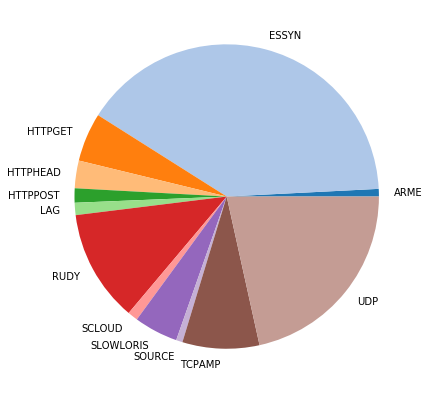

In [16]:
top_10_attacked_domain['amount of attacks'].plot(kind='pie',ylabel='',figsize=(7,7), colors=plt.cm.tab20.colors)

#### ESSYN
ESSYN is the most frequently used atttack type. An ESSYN flood attack, also known as an XSYN flood, is a variation of the often used SYN flood. In a SYN flood an attacker sends a large amount of TCP SYN packets to a target. Each of these SYN packets causes the server to open a network connection for a specific client. The server acknowledges this by sending an ACK packet back to the client, it then waits for the client to also acknowledge this by sending an ACK packet. This however is never done by the client, causing a large amount of half-open connections, which consume resources. If too many of the server's resources are exhausted, the server will no longer respond to legitimate requests: a successful DDoS attack. 

(Stateful) firewalls and other security systems have started to recognize and succesfully prevent DDoS attacks using SYN floods. That is why a variation of the SYN flood has been created: ESSYN or XSYN floods. The attack is conducted using a large amount of IP addresses, which each create a connection. Each of these IP addresses adds a record in the firewall state table. At one point the firewall state table is full and will no longer accept any additional inbound connections, once again denying service to legitimate users: a successful DDoS attack.

We can actually see that the most amount of unique server addresses have been used for ESSYN attacks:

In [17]:
df.groupby('type').server_used_in_th_attack.unique().apply(len)

type
ARME           14
ESSYN        1189
HTTPGET        21
HTTPHEAD       19
HTTPPOST       13
LAG           242
RUDY           26
SCLOUD        175
SLOWLORIS      20
SOURCE         11
TCPAMP        681
UDP          1000
Name: server_used_in_th_attack, dtype: int64

#### UDP
After ESSYN Floods, the most often occuring attack type is the UDP flood. UDP floods are similar to SYN floods in the sense that a large amount of UDP packets are sent by a botnet to one target. These UDP packets contain a port on the server, for which the packet was intended. The server needs to check if a specific application is listening on that port. If no application is listening, the server responds with a packet to the client. By sending UDP packets with many different ports, the server has to process many different ports and has to respond to each packet, consuming a large amount of resources. Once all resources are exhausted, the server cannot accept any legitimate connections: a successful DDoS Attack. In the table above we can see that a large amount of different IP addresses are used by the UDP attack.

#### RUDY
RUDY, short for ```R-U-Dead-Yet?``` is an attack tool that makes use of a so-called <i>slow attack</i>. This means that the attack does not try to flood the target with many packets, but attempts to open a few connections to the target and leave those connections open for a long amount of time. RUDY does this by using forms on the website. RUDY creates a form submission that says a large amount of content is following (HTTP Post request with long 'content-length'). RUDY then sends the content, one byte at a time with a large amount of time inbetween (typically 10 seconds). The server does not close the connection since the server still expects content (due to the large content-length set in the header). This results in a large amount of threads that have data to process, eventually using up all of the resources of the website, causing it to crash.

<i>Information about the UDP flood and ESSYN flood types has been sourced from the Multi-State Information Sharing and Analysis Center's (MS-ISAC) Guide to DDoS attacks. This guide was created in November 2017 and was retrieved October 16, 2020 from https://www.cisecurity.org/wp-content/uploads/2017/03/Guide-to-DDoS-Attacks-November-2017.pdf</i>


<i>Information about RUDY has been sourced from the imperva Learning Center in the article 'R.U.D.Y. (R-U-Dead-Yet?)' and was retrieved October 16, 2020 from https://www.imperva.com/learn/ddos/rudy-r-u-dead-yet/</i>

### 7. Owner ID that conducted most attacks
The dataset contains an id that identifies each of the users that started an attack. The most amount of attacks are conducted by the following three user id's: 272, 197 and 111, with respectively 2307 attacks, 2020 attacks and 1965 attacks.

In [18]:
df.groupby('client_attacker').count()["id"].sort_values(ascending=False)[:3]

client_attacker
272    2307
197    2028
111    1965
Name: id, dtype: int64

### 8. Attacks on 'krebsonsecurity.com'
The blog on which the leaked database is uploaded is called KrebsOnSecurity, a security news and investigation site. The dataset also contains a few records which point to an attack on KrebsOnSecurity. In total there are 15 attacks on KrebsOnSecurity in the attack records.

In [19]:
df.query('"krebsonsecurity.com" in victim').shape[0]

15

These 15 attacks had a combined duration of 108000 seconds, which is 1,25 days

In [20]:
df.query('"krebsonsecurity.com" in victim')["duration"].sum()

108000

### 9. Attacker
We wondered if the people that had conducted the most amount of attacks, have mainly targeted the same victims or different victims. In order to quantify this, we look at the ratio of unique victims to total amount of attacks, per attacker. A high ratio (close to 1) indicates that the attacks of the attacker were mainly conducted on different victims. A low ratio (close to 0) indicates that the attacker has mainly targeted the same victim in multiple attacks. This is seen intuitively as follows:

An attacker conducts 100 attacks on 1 victim. The ratio is $1/100 = 0,01$.<br>An attacker conducts 100 attacks on 2 different victims. The ratio is $2/100 = 0,02$.<br>An attacker conducts 100 attacks on 100 different victims. The ratio is $100/100 = 1$.


,victim,amount_of_attacks,amount_of_unique_victims,ratio
client_attacker,,,,
272,"[yourpshome.net, yourpshome.net, yourpshome.ne...",2307,7,0.003034
299,"[212.7.214.197, 212.7.214.197, 212.7.214.197, ...",198,3,0.015152
297,"[166.78.109.77, 166.78.109.77, 166.78.109.77, ...",214,5,0.023364
298,"[166.78.109.77, 166.78.109.77, 166.78.109.77, ...",213,5,0.023474
36,"[186.202.153.45, 186.202.153.45, 186.202.153.4...",418,10,0.023923
...,...,...,...,...
170,[81.141.239.180],1,1,1.000000
270,[174.138.175.30],1,1,1.000000
84,"[68.46.11.11, 174.59.10.96]",2,2,1.000000


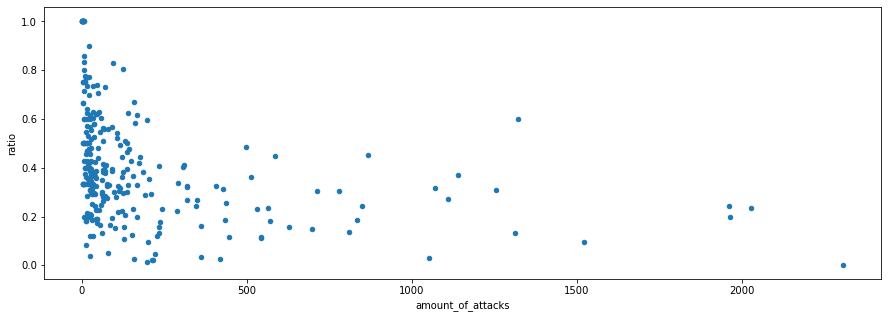

In [21]:
df_grouped = df.groupby('client_attacker').victim.apply(list).to_frame()
df_grouped = df_grouped.assign(**{
    'amount_of_attacks': [len(x) for x in df_grouped['victim']], 
    'amount_of_unique_victims': [len(list(dict.fromkeys(x))) for x in df_grouped['victim']]
    })
df_grouped['ratio'] = df_grouped.apply(lambda row: row.amount_of_unique_victims/row.amount_of_attacks, axis=1)


df_grouped.plot.scatter(x="amount_of_attacks", y="ratio", figsize=(15,5))
df_grouped.sort_values('ratio', ascending=True)

As we can see in the scatter plot above, the more frequent attackers have a low ratio, below 0.5, which indicates that they mainly attack the same victims. When the amount of attacks decreases, roughly below the 300 attacks, there appear to be more attackers that attack relatively more different victims.

### 10. Amount of attacks started per weekday
We wondered on which day of the week most of the attacks were launched. It appears that more attacks are launched in the weekend than during the week, with most of the attacks launched on Saturday.

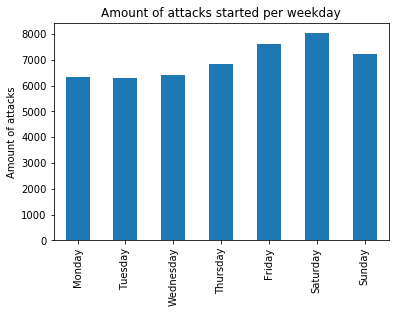

In [22]:
import calendar
day_df = pd.to_datetime(df.time, unit='s').dt.dayofweek.value_counts().sort_index().to_frame()
day_df.index = list(calendar.day_name)
plt = day_df.plot(kind='bar',legend=False, title="Amount of attacks started per weekday",ylabel="Amount of attacks")

## Conclusion
The analysis yielded the following insights into the service offered by TWBooter. We found out that 277 users are responsible for 48773 attacks, which is about $48773/277=176$ attacks per user, which we found to be quite a lot. Customers of TWBooter targeted more IP addresses than domains. This could be because more persons have been attacked than servers. A person's residential network connection usually does not have a domain pointed to it, whereas a server is more likely to have a domainname point to it. A reason why there are domain names in the dataset could be that inexperienced people were unable to find out the IP address of a website and have chosen the easier way of just using the domain name as a target. Also, the majority of types involved in the attacks were using ESSYN, UDP and RUDY. ESSYN and UDP attacks required many different source IP addresses, whereas RUDY attacks used a select few servers in the attack. In overall, the customers that are using the booter for a large amount of attacks, tend to target the same victim. The most devastating attacks can be expected to be those that denied the service of a website or an individual for almost 6 days (500.000 seconds), at a time. The loss over those 6 days and the cost of getting the service up again will probably be severe.


TWBooter appears to even have loyal customers, some of which ordered several hundred to thousands of attacks on the service. These attackers can be expected to not just wanting to annoy their targets, but intentionally wanting to cause damage to them. While TWBooter can claim their services are legal, due to the fact that they are supposed to only attack server's owned by an attacker, at some point they should also have investigated whether their top attackers really owned (a majority of the) servers. To lower the ease of DDoS attacks, regulation has to be set up for these services that force them to do such a check on their customers. Other customer validation procedures, such as KYC (Know Your Customer, a method where a service identifies their customers via an ID-card or Electric Bill), could also aid in this. The data in this analysis is very narrow: we do not have any information about the scale of the attack traffic and we do not know if the attacks even took place or was succesful. E.g. some records might be erroneuous or attacks may have been stopped manually long before the attack had the duration that is indicated in the dataset. Additionally there may be users that use multiple accounts on TWBooter, for example to prevent being pinpointed by law enforcement if a database leak occurs, or even users that used TWBooter to resell DDoS services. For further investigation it would be interesting to find out for what percentage of Booter attacks during 2013 TWBooter could be accused for, or what the total economic damage caused, but also the total gain of the operators of TWBooter was.
